In [175]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.special import lambertw
from tqdm import tqdm

In [176]:
df = pd.read_csv('data_pp.csv')
df.head()

,date,shizuoka_p,shizuoka_qual,shizuoka_homo,fuji_p,fuji_qual,fuji_homo
0,Jan-00,1015.9,8,1,630.8,5,1
1,Feb-00,1010.5,8,1,622.8,5,1
2,Mar-00,1010.8,8,1,626.9,8,1
3,Apr-00,1008.8,8,1,632.9,8,1
4,May-00,1009.5,8,1,640.2,8,1


In [177]:
print(df['shizuoka_qual'].unique())
print(df['fuji_qual'].unique())

[8 5]
[5 8 4 1]


In [178]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           240 non-null    object 
 1   shizuoka_p     240 non-null    float64
 2   shizuoka_qual  240 non-null    int64  
 3   shizuoka_homo  240 non-null    int64  
 4   fuji_p         239 non-null    float64
 5   fuji_qual      240 non-null    int64  
 6   fuji_homo      240 non-null    int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 13.2+ KB
None


In [179]:
df[df['fuji_p'].isnull()]

,date,shizuoka_p,shizuoka_qual,shizuoka_homo,fuji_p,fuji_qual,fuji_homo
232,May-19,1011.4,8,1,NaN,1,1


In [180]:
g = 9.81
rho = 1.23
R = 287
gamma = 0.0065

## LambertのW関数を用いる
$x\ln(x)$は初等関数では求められないが、LambertのW関数を用いることで値が求まる  
>LambertのW関数は[こちら](https://oshiete.goo.ne.jp/qa/2726817.html)より求めた  
>SciPyのlambertw関数に関するドキュメントは[こちら](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.lambertw.html)

In [181]:
print(np.real(lambertw(14*(rho*g)*np.exp(-np.log(1015.9*100)))))
print(np.exp(np.real(lambertw(14*(rho*g)*np.exp(-np.log(1015.9*100)))) + np.log(1015.9*100)))

0.0016600846297460544
101758.78806000463


In [182]:
print(R*gamma/g, rho*R*gamma*14, 100000**(R*gamma/g))

0.1901630988786952 32.12391 8.929260525618524


In [199]:
#df['sea_level_p2'] = np.round((rho * R * gamma * 14) * (df['shizuoka_p']*100)**(R*gamma/g))

In [200]:
df['sea_level_p'] = np.round(np.exp(np.real(lambertw(14*(rho*g)*np.exp(-np.log(df['shizuoka_p']*100)))) 
                                    + np.log(df['shizuoka_p']*100))/100, decimals=1)
df['fuji_z_est'] = np.round(df['sea_level_p']*100/(rho * g) * np.log(df['sea_level_p'] / df['fuji_p']))
#df['fuji_z_from_shizuoka'] = np.round(df['sea_level_p']*100/(rho * g) * np.log(df['shizuoka_p'] / df['fuji_p'])) + 14
#df['fuji_z_approx'] = np.round(df['shizuoka_p']*100/(rho * g) * np.log(df['shizuoka_p'] / df['fuji_p'])) + 14
df['fuji_z_change_T2'] = np.round(df['sea_level_p']*100/(rho*R*gamma)*(1-(df['fuji_p']/df['sea_level_p2'])**(R*gamma/g)))
#df['diff'] = df['fuji_z_est'] - 3776

df['relative_accuracy'] = (df['fuji_z_est'] - 3776)/3776*100
df['sea_level_T2'] = np.round(df['sea_level_p2']*100/(rho*R))
#df['ln(sea_level_p/fuji_p)'] = np.log(df['sea_level_p']/df['fuji_p'])
df['date_pp'] = np.linspace(2000, 2020, 20*12, endpoint=False)

In [185]:
col = ['date', 'shizuoka_p', 'fuji_p', 'sea_level_p2', 'sea_level_p']

In [233]:
df[col].head(13)
#df[['date', 'shizuoka_p', 'fuji_p']][3:240:12].to_csv('table4.csv', index=False)

,date,shizuoka_p,fuji_p,sea_level_p2,sea_level_p
0,Jan-00,1015.9,630.8,1017.6,1017.6
1,Feb-00,1010.5,622.8,1012.2,1012.2
2,Mar-00,1010.8,626.9,1012.5,1012.5
3,Apr-00,1008.8,632.9,1010.5,1010.5
4,May-00,1009.5,640.2,1011.2,1011.2
5,Jun-00,1007.1,643.2,1008.8,1008.8
6,Jul-00,1006.6,647.0,1008.3,1008.3
7,Aug-00,1009.7,650.0,1011.4,1011.4
8,Sep-00,1009.7,646.6,1011.4,1011.4
9,Oct-00,1014.6,644.8,1016.3,1016.3


In [187]:
for i in df['shizuoka_p'].head(5):
    print(type(i))

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>


In [188]:
xx = []
for shizu_p in tqdm(df['shizuoka_p']):
    #First index
    i = 0

    #Substitute 0 to each list index[0]
    x = []
    
    #First x value
    x.append(shizu_p*100)

    #Newton method(計算したxの値が10**(-15)より小さくなるまで繰り返す)
    while (np.abs((x[i])**(R*gamma/g)-rho*R*gamma*14*((x[i])**(R*gamma/g - 1))-(shizu_p*100)**(R*gamma/g)) > 10**(-15)):
        #x_{n}における次のxを計算
        x.append(x[i] - (((x[i])**(R*gamma/g)-rho*R*gamma*14*((x[i])**(R*gamma/g - 1))-(shizu_p*100)**(R*gamma/g))/
                         ((R*gamma/g)*(x[i])**((R*gamma/g) - 1)-rho*R*gamma*14*(R*gamma/g-1)*(x[i])**((R*gamma/g)-2))))

        #インデックスを次へ
        i += 1

    #ループを抜け出した際の最後のxをxxに格納
    xx.append(x[i])

numpy_xx = np.array(xx)
df['sea_level_p2'] = np.round(numpy_xx/100, decimals=1)
#df['sea_level_p2'] = numpy_xx/100
print('done!')

100%|██████████| 240/240 [00:00<00:00, 18509.05it/s]

done!


In [189]:
101758.8147**(R*gamma/g)-rho*R*gamma*14*(101758.8147**(R*gamma/g - 1))-(1015.9*100)**(R*gamma/g)

2.412257060768752e-10

In [190]:
df['fuji_z_est'].mean()

3880.878661087866

In [191]:
print(df['relative_accuracy'].max())
print(df['relative_accuracy'].min())

8.501059322033898
-2.5158898305084745


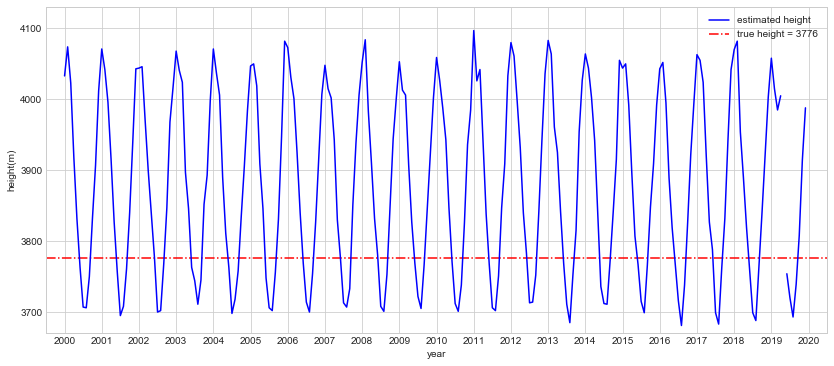

In [192]:
plt.figure(figsize = (14, 6))
plt.style.use('seaborn-whitegrid')
plt.plot(df['date_pp'], df['fuji_z_est'], 'b', label='estimated height')
#plt.plot(df['date'][:72], df['fuji_height'][:72])
plt.hlines([3776], 1999.5, 2020.5, "r", linestyles='dashdot', label='true height = 3776')
#plt.vlines(np.arange(0, 21)-1/24, 3670, 4180, 'k', linestyles = 'dotted')
plt.xticks(np.arange(2000, 2021))
plt.xlim([1999.5, 2020.5])
plt.ylim([3670, 4130])
plt.xlabel('year')
plt.ylabel('height(m)')
plt.legend(loc='upper right')
plt.savefig('plot1.jpg')
plt.show()

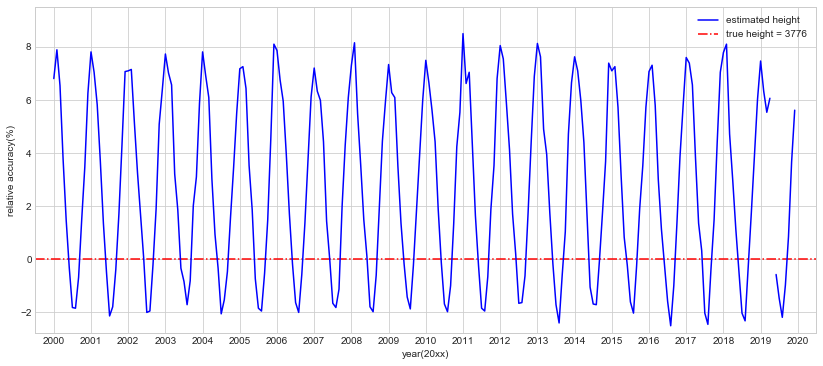

In [193]:
plt.figure(figsize = (14, 6))
plt.style.use('seaborn-whitegrid')
plt.plot(df['date_pp'], df['relative_accuracy'], 'b', label='estimated height')
#plt.plot(df['date'][:72], df['fuji_height'][:72])
plt.hlines([0], 1999.5, 2020.5, "r", linestyles='dashdot', label='true height = 3776')
#plt.vlines(np.arange(0, 21)-1/24, 3670, 4180, 'k', linestyles = 'dotted')
plt.xticks(np.arange(2000, 2021))
plt.xlim([1999.5, 2020.5])
plt.ylim([-2.8, 9.5])
plt.xlabel('year(20xx)')
plt.ylabel('relative accuracy(%)')
plt.legend(loc='upper right')
plt.savefig('acc.jpg')
plt.show()

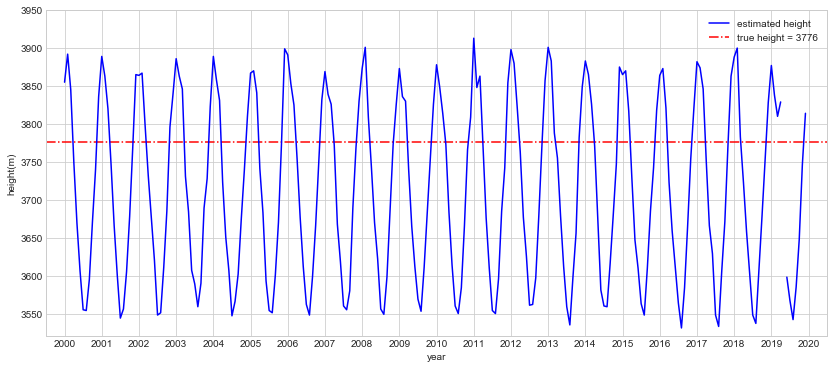

In [201]:
plt.figure(figsize = (14, 6))
plt.style.use('seaborn-whitegrid')
plt.plot(df['date_pp'], df['fuji_z_change_T2'], 'b', label='estimated height')
#plt.plot(df['date'][:72], df['fuji_height'][:72])
plt.hlines([3776], 1999.5, 2020.5, "r", linestyles='dashdot', label='true height = 3776')
#plt.vlines(np.arange(0, 21)-1/24, 3520, 3950, 'k', linestyles = 'dotted')
plt.xticks(np.arange(2000, 2021))
plt.xlim([1999.5, 2020.5])
plt.ylim([3520, 3950])
plt.xlabel('year')
plt.ylabel('height(m)')
plt.legend(loc='upper right')
plt.savefig('plot2.jpg')
plt.show()

In [202]:
df['relative_accuracy2'] = (df['fuji_z_change_T2'] - 3776)/3776*100

In [203]:
df['shizuoka_est_T'] = df['sea_level_T2'] -273 - 0.1

In [204]:
df['true_temp'] = df_temp['temp']

In [205]:
df[['date', 'fuji_z_change_T2', 'relative_accuracy2', 'shizuoka_est_T', 'true_temp']].head(12).to_csv('table2.csv', index=False)

In [171]:
print(df['relative_accuracy2'].max(), df['relative_accuracy2'].min())

-152.489406779661 -156.01165254237287


In [172]:
df_temp = pd.read_csv('data_t.csv')
df_temp.head()

,date,temp
0,Jan-00,8.3
1,Feb-00,5.9
2,Mar-00,9.6
3,Apr-00,14.9
4,May-00,19.6


In [213]:
df_temp['sea_level_T'] = df_temp['temp'] - 0.1
df_temp['fuji_est'] = (df_temp['sea_level_T']+273.15)/gamma*(1-(df['fuji_p']/df['sea_level_p'])**(R*gamma/g))
df_temp['rho'] = df['sea_level_p']*100/(R*(df_temp['sea_level_T'] + 273))
df_temp['relative_accuracy3'] = (df_temp['fuji_est'] - 3776)/3776*100

In [216]:
df_temp.head(12).to_csv('table3.csv', index=False)

In [224]:
df_temp.tail(24)

,date,temp,sea_level_T,fuji_est,rho,relative_accuracy3,date_pp
216,Jan-18,6.1,6.0,3777.778268,1.266719,0.047094,2018.000000
217,Feb-18,6.7,6.6,3788.944865,1.266742,0.342820,2018.083333
218,Mar-18,12.6,12.5,3753.167723,1.240443,-0.604668,2018.166667
219,Apr-18,16.9,16.8,3755.701849,1.219873,-0.537557,2018.250000
220,May-18,20.0,19.9,3741.130105,1.203274,-0.923461,2018.333333
221,Jun-18,23.0,22.9,3730.421872,1.188366,-1.207048,2018.416667
222,Jul-18,28.1,28.0,3732.073029,1.169852,-1.163320,2018.500000
223,Aug-18,28.6,28.5,3733.353967,1.165947,-1.129397,2018.583333
224,Sep-18,24.0,23.9,3735.133088,1.188706,-1.082281,2018.666667
225,Oct-18,20.0,19.9,3749.025273,1.207676,-0.714373,2018.750000


In [217]:
df_temp['date_pp'] = np.linspace(2000, 2020, 20*12, endpoint=False)

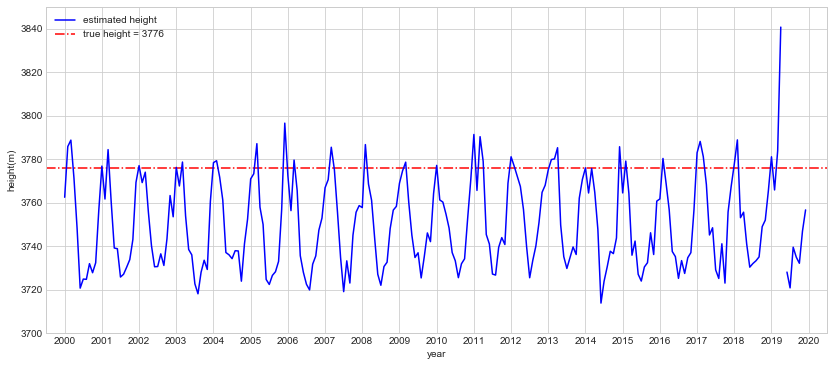

In [221]:
plt.figure(figsize = (14, 6))
plt.style.use('seaborn-whitegrid')
plt.plot(df_temp['date_pp'], df_temp['fuji_est'], 'b', label='estimated height')
#plt.plot(df['date'][:72], df['fuji_height'][:72])
plt.hlines([3776], 1999.5, 2020.5, "r", linestyles='dashdot', label='true height = 3776')
#plt.vlines(np.arange(0, 21)-1/24, 3520, 3950, 'k', linestyles = 'dotted')
plt.xticks(np.arange(2000, 2021))
plt.xlim([1999.5, 2020.5])
plt.ylim([3700, 3850])
plt.xlabel('year')
plt.ylabel('height(m)')
plt.legend(loc='upper left')
plt.savefig('plot3.jpg')
plt.show()

In [222]:
print(df_temp['relative_accuracy3'].max(), df_temp['relative_accuracy3'].min())

1.7165418191352901 -1.6446797149549295


In [173]:
df[['date', 'shizuoka_p', 'fuji_p', 'sea_level_p', 'ln(sea_level_p/fuji_p)', 'fuji_z_est', 'diff', 
   'relative_accuracy']].head(12).to_csv('table.csv', index=False)

In [150]:
print(df['sea_level_T'].min(), df['sea_level_T'].max())

285.0 289.0


In [163]:
df_temp = pd.read_csv('temp.csv')

In [164]:
df_temp['mean_temp'] = (df_temp['shizuoka_temp'] + df_temp['fuji_temp']) / 2

In [230]:
df_temp[3:240:12]

,date,temp,sea_level_T,fuji_est,rho,relative_accuracy3,date_pp
3,Apr-00,14.9,14.8,3771.329993,1.223386,-0.123676,2000.25
15,Apr-01,15.3,15.2,3760.546543,1.226283,-0.409255,2001.25
27,Apr-02,16.4,16.3,3755.787418,1.222824,-0.535291,2002.25
39,Apr-03,16.0,15.9,3754.021323,1.222949,-0.582062,2003.25
51,Apr-04,16.3,16.2,3761.284734,1.218187,-0.389705,2004.25
63,Apr-05,15.5,15.4,3757.990813,1.225191,-0.476938,2005.25
75,Apr-06,13.9,13.8,3765.665860,1.227288,-0.273680,2006.25
87,Apr-07,14.4,14.3,3775.290759,1.229518,-0.018783,2007.25
99,Apr-08,15.4,15.3,3761.205125,1.224407,-0.391813,2008.25
111,Apr-09,15.4,15.3,3760.132341,1.224044,-0.420224,2009.25


In [166]:
df_temp.head(12).to_csv('table_temp.csv', index=False)